# Изучить набор данных, исследовать на пропуске, выбросы, балансировку по классам и тд

### Проверка на пропуски

In [1]:
import pandas as pd

# Загрузка данных
data = pd.read_csv('train.csv')

# Проверка на пропуски
print(data.isnull().sum())

ID       0
Class    0
dtype: int64


### Проверка на выбросы

In [2]:
# Проверка уникальных значений в столбце Class
print(data['Class'].unique())

['MIDDLE' 'YOUNG' 'OLD']


### Проверка на балансировку классов

Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64


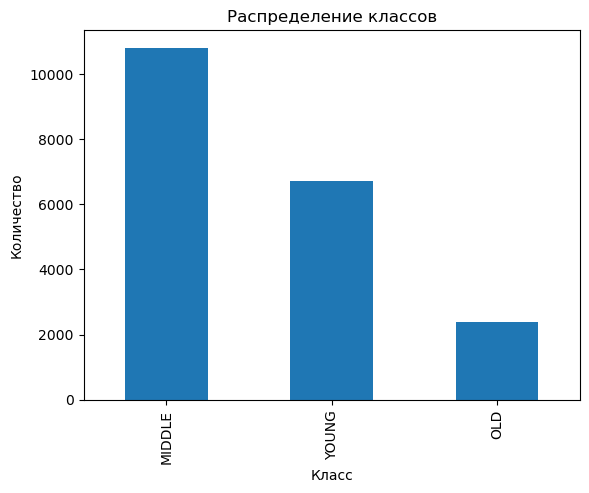

In [3]:
import matplotlib.pyplot as plt

# Подсчет количества примеров в каждом классе
class_counts = data['Class'].value_counts()
print(class_counts)

# Визуализация распределения классов
class_counts.plot(kind='bar')
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.show()

При таком распределении классов (MIDDLE: 10804, YOUNG: 6706, OLD: 2396) видно, что данные сильно несбалансированы. Класс MIDDLE значительно преобладает, а класс OLD представлен меньше всего. Это может привести к тому, что модель будет лучше предсказывать класс MIDDLE, но хуже справляться с классами YOUNG и OLD.

### Считываем файлы и пробуем их сбалансировать

In [4]:
from sklearn.model_selection import train_test_split

# Преобразование категорий в числовые значения
data['Class'] = data['Class'].map({'YOUNG': 0, 'MIDDLE': 1, 'OLD': 2})

# Разделение данных на обучающую и тестовую выборки
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Функция для загрузки изображений
def load_images(data, path):
    images = []
    for img_name in data['ID']:
        img = load_img(path + img_name, target_size=(100, 100))  
        img = img_to_array(img)
        images.append(img)
    return np.array(images)

# Загрузка изображений
train_images = load_images(train_data, 'Train/')
test_images = load_images(test_data, 'Train/')

print(len(train_images))

15924


In [7]:
# Проверка распределения классов в исходных данных
print("Исходное распределение классов:")
print(data['Class'].value_counts())

# Проверка распределения классов в обучающей выборке
print("\nРаспределение классов в обучающей выборке:")
print(train_data['Class'].value_counts())

# Проверка распределения классов в тестовой выборке
print("\nРаспределение классов в тестовой выборке:")
print(test_data['Class'].value_counts())

Исходное распределение классов:
Class
1    10804
0     6706
2     2396
Name: count, dtype: int64

Распределение классов в обучающей выборке:
Class
1    8623
0    5376
2    1925
Name: count, dtype: int64

Распределение классов в тестовой выборке:
Class
1    2181
0    1330
2     471
Name: count, dtype: int64


### Балансируем наши данные при помощью RandomOverSampler

In [8]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import numpy as np

# Преобразование изображений в одномерные массивы
X = train_images.reshape(train_images.shape[0], -1)  # Преобразуем изображения в одномерные массивы
y = train_data['Class'].values  # Метки классов

# Применение RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Проверка балансировки
print("До балансировки:", Counter(y))
print("После балансировки:", Counter(y_resampled))

# Преобразование обратно в формат изображений
X_resampled = X_resampled.reshape(-1, 100, 100, 3)  # Преобразуем обратно в изображения

# Обновление train_data и train_images
train_images = X_resampled
train_data = train_data.iloc[ros.sample_indices_]  # Обновляем метки в train_data

До балансировки: Counter({1: 8623, 0: 5376, 2: 1925})
После балансировки: Counter({1: 8623, 0: 8623, 2: 8623})


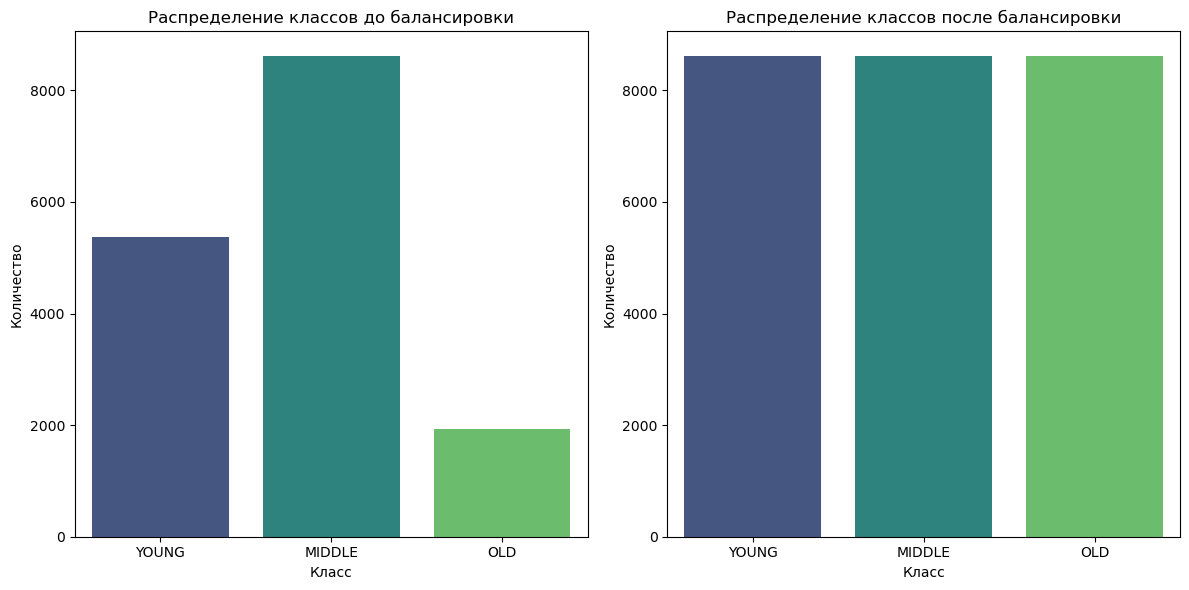

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Распределение классов до балансировки
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=y, palette='viridis')
plt.title('Распределение классов до балансировки')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.xticks(ticks=[0, 1, 2], labels=['YOUNG', 'MIDDLE', 'OLD'])

# Распределение классов после балансировки
plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled, palette='viridis')
plt.title('Распределение классов после балансировки')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.xticks(ticks=[0, 1, 2], labels=['YOUNG', 'MIDDLE', 'OLD'])

plt.tight_layout()
plt.show()

## Пробуем обучить модель RandomForrest на наших сбалансированных данных

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Преобразуем изображения в одномерные массивы для Random Forest
X_train_rf = train_images.reshape(train_images.shape[0], -1)
y_train_rf = train_data['Class'].values

X_test_rf = test_images.reshape(test_images.shape[0], -1)
y_test_rf = test_data['Class'].values

print(len(X_train_rf))
# Создаем и обучаем модель Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Предсказание на тестовых данных
y_pred_rf = rf_model.predict(X_test_rf)

# Оценка модели
print("Random Forest Classification Report:")
print(classification_report(y_test_rf, y_pred_rf, target_names=['YOUNG', 'MIDDLE', 'OLD']))
print("Confusion Matrix:")
print(confusion_matrix(y_test_rf, y_pred_rf))

25869
Random Forest Classification Report:
              precision    recall  f1-score   support

       YOUNG       0.71      0.61      0.66      1330
      MIDDLE       0.70      0.85      0.77      2181
         OLD       0.64      0.31      0.42       471

    accuracy                           0.70      3982
   macro avg       0.69      0.59      0.61      3982
weighted avg       0.70      0.70      0.69      3982

Confusion Matrix:
[[ 808  509   13]
 [ 269 1844   68]
 [  59  267  145]]


### Применим балансировку SMOTE, чтобы улучшить нашу точность для OLD

In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Преобразуем изображения в одномерные массивы для Random Forest
X_train_rf = train_images.reshape(train_images.shape[0], -1)
y_train_rf = train_data['Class'].values

X_test_rf = test_images.reshape(test_images.shape[0], -1)
y_test_rf = test_data['Class'].values

# Применяем SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_rf, y_train_rf)

# Обучите модель на сбалансированных данных
rf_model_balanced = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model_balanced.fit(X_train_balanced, y_train_balanced)

# Оценка модели
y_pred_balanced = rf_model_balanced.predict(X_test_rf)
print(classification_report(y_test_rf, y_pred_balanced, target_names=['YOUNG', 'MIDDLE', 'OLD']))

              precision    recall  f1-score   support

       YOUNG       0.71      0.61      0.66      1330
      MIDDLE       0.70      0.85      0.77      2181
         OLD       0.64      0.31      0.42       471

    accuracy                           0.70      3982
   macro avg       0.69      0.59      0.61      3982
weighted avg       0.70      0.70      0.69      3982



### Видим, что стало только хуже, попробуем поиграться с гиперпараметрами

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_rf, y_train_rf)

print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Преобразуем изображения в одномерные массивы для Random Forest
X_train_rf = train_images.reshape(train_images.shape[0], -1)
y_train_rf = train_data['Class'].values

X_test_rf = test_images.reshape(test_images.shape[0], -1)
y_test_rf = test_data['Class'].values

print(len(X_train_rf))
# Создаем и обучаем модель Random Forest
rf_model = RandomForestClassifier(n_estimators=200,min_samples_split=2, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Предсказание на тестовых данных
y_pred_rf = rf_model.predict(X_test_rf)

# Оценка модели
print("Random Forest Classification Report:")
print(classification_report(y_test_rf, y_pred_rf, target_names=['YOUNG', 'MIDDLE', 'OLD']))
print("Confusion Matrix:")
print(confusion_matrix(y_test_rf, y_pred_rf))

25869
Random Forest Classification Report:
              precision    recall  f1-score   support

       YOUNG       0.72      0.60      0.65      1330
      MIDDLE       0.70      0.85      0.77      2181
         OLD       0.63      0.30      0.41       471

    accuracy                           0.70      3982
   macro avg       0.68      0.58      0.61      3982
weighted avg       0.70      0.70      0.69      3982

Confusion Matrix:
[[ 797  521   12]
 [ 253 1856   72]
 [  56  274  141]]


### Как видим это тоже не дало особого результата 
### В дальнейшем будем использовать выборку с RandomOverSampler

## Для реализации глубокого/нейросетевого подхода можно использовать сверточную нейронную сеть (CNN), которая хорошо подходит для задач классификации изображений.

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix

# Преобразуем метки классов в one-hot encoding
y_train_cnn = tf.keras.utils.to_categorical(y_train_rf, num_classes=3)
y_test_cnn = tf.keras.utils.to_categorical(y_test_rf, num_classes=3)

# Нормализация данных (приведение значений пикселей к диапазону [0, 1])
X_train_cnn = train_images / 255.0
X_test_cnn = test_images / 255.0

# Создание модели CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

# Компиляция модели
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучение модели
history = model.fit(X_train_cnn, y_train_cnn, epochs=20, batch_size=32, validation_split=0.2)

# Оценка модели на тестовых данных
y_pred_cnn = model.predict(X_test_cnn)
y_pred_cnn = tf.argmax(y_pred_cnn, axis=1)

# Вывод результатов
print("CNN Classification Report:")
print(classification_report(y_test_rf, y_pred_cnn, target_names=['YOUNG', 'MIDDLE', 'OLD']))
print("Confusion Matrix:")
print(confusion_matrix(y_test_rf, y_pred_cnn))

E:\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
647/647 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - accuracy: 0.5143 - loss: 0.9600 - val_accuracy: 0.3348 - val_loss: 1.1229
Epoch 2/20
647/647 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.6458 - loss: 0.7815 - val_accuracy: 0.3597 - val_loss: 1.2778
Epoch 3/20
647/647 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.6938 - loss: 0.7022 - val_accuracy: 0.7167 - val_loss: 0.7260
Epoch 4/20
647/647 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.7357 - loss: 0.6249 - val_accuracy: 0.7165 - val_loss: 0.7037
Epoch 5/20
647/647 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.7770 - loss: 0.5388 - val_accuracy: 0.7646 - val_loss: 0.6099
Epoch 6/20
647/647 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.8171 - loss: 0.4471 - val_accuracy: 0.7973 - val_loss: 0.5266
Epoch 7/20
647/647 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.8378 - loss: 0.4047 - val_accuracy: 0.7783 - val_loss: 0.4947
Epoch 8/20
647/647 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.8604 - loss: 0.3407 - 

### Сверточная сеть дала лучше результат нежели RandomForrest

### Попробуем использовать модель XGBoost.  В основе XGBoost лежит алгоритм градиентного бустинга деревьев решений. Градиентный бустинг — это техника машинного обучения для задач классификации и регрессии, которая строит модель предсказания в форме ансамбля слабых предсказывающих моделей, обычно деревьев решений

In [33]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Преобразуем изображения в одномерные массивы для XGBoost
X_train_xgb = X_train_rf  # Уже преобразовано ранее
X_test_xgb = X_test_rf    # Уже преобразовано ранее
y_train_xgb = y_train_rf  # Уже преобразовано ранее
y_test_xgb = y_test_rf    # Уже преобразовано ранее

# Создаем модель XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=200,      # Количество деревьев
    max_depth=5,           # Максимальная глубина дерева
    learning_rate=0.1,     # Скорость обучения
    random_state=42,
    n_jobs=-1              # Использовать все ядра процессора
)

# Обучение модели
xgb_model.fit(X_train_xgb, y_train_xgb)

# Предсказание на тестовых данных
y_pred_xgb = xgb_model.predict(X_test_xgb)

# Оценка модели
print("XGBoost Classification Report:")
print(classification_report(y_test_xgb, y_pred_xgb, target_names=['YOUNG', 'MIDDLE', 'OLD']))

# Визуализация матрицы ошибок
print(confusion_matrix(y_test_rf, y_pred_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

       YOUNG       0.71      0.70      0.71      1330
      MIDDLE       0.77      0.75      0.76      2181
         OLD       0.47      0.56      0.51       471

    accuracy                           0.71      3982
   macro avg       0.65      0.67      0.66      3982
weighted avg       0.72      0.71      0.71      3982

[[ 933  330   67]
 [ 321 1635  225]
 [  58  149  264]]


### XGBoost показал хуже результат чем CNN

## KNN — это простой, но эффективный алгоритм для задач классификации. Он классифицирует объекты на основе их сходства с ближайшими соседями.

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Создаем модель KNN
knn_model = KNeighborsClassifier(n_neighbors=5)

# Обучение модели
knn_model.fit(X_train_rf, y_train_rf)

# Предсказание на тестовых данных
y_pred_knn = knn_model.predict(X_test_rf)

# Оценка модели
print("KNN Classification Report:")
print(classification_report(y_test_rf, y_pred_knn, target_names=['YOUNG', 'MIDDLE', 'OLD']))

# Визуализация матрицы ошибок
print(confusion_matrix(y_test_rf, y_pred_xgb))

KNN Classification Report:
              precision    recall  f1-score   support

       YOUNG       0.65      0.57      0.61      1330
      MIDDLE       0.73      0.61      0.67      2181
         OLD       0.31      0.65      0.42       471

    accuracy                           0.60      3982
   macro avg       0.56      0.61      0.56      3982
weighted avg       0.65      0.60      0.62      3982

[[ 933  330   67]
 [ 321 1635  225]
 [  58  149  264]]


### КNN показал себя хуже всех

# Подведем итоги моделей 

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Функция для вычисления метрик
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Сбор метрик для всех моделей
results = [
    evaluate_model(y_test_rf, y_pred_rf, 'Random Forest'),
    evaluate_model(y_test_rf, y_pred_cnn, 'CNN'),
    evaluate_model(y_test_rf, y_pred_xgb, 'XGBoost'),
    evaluate_model(y_test_rf, y_pred_knn, 'KNN')
]

# Преобразуем результаты в DataFrame для удобства
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

           Model  Accuracy  Precision    Recall  F1-Score
0  Random Forest  0.701657   0.698273  0.701657  0.687241
1            CNN  0.754897   0.759644  0.754897  0.756682
2        XGBoost  0.711200   0.717293  0.711200  0.713715
3            KNN  0.603214   0.654795  0.603214  0.618067


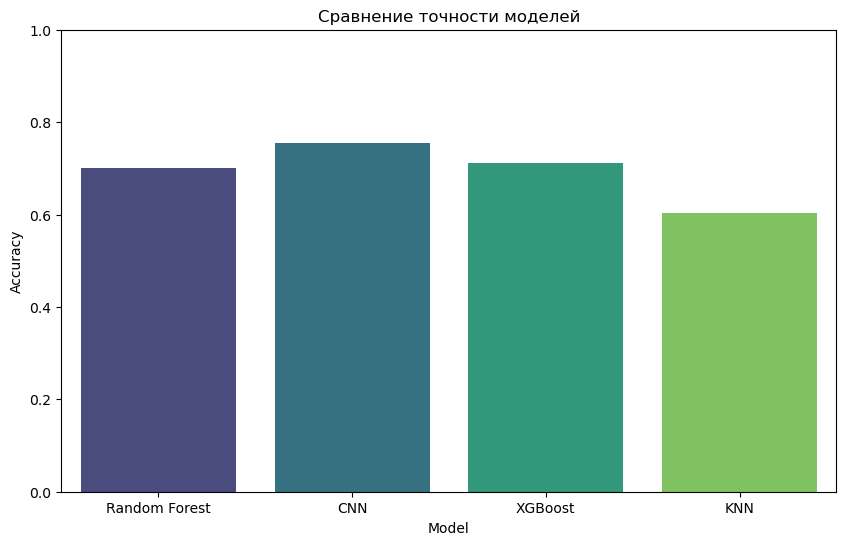

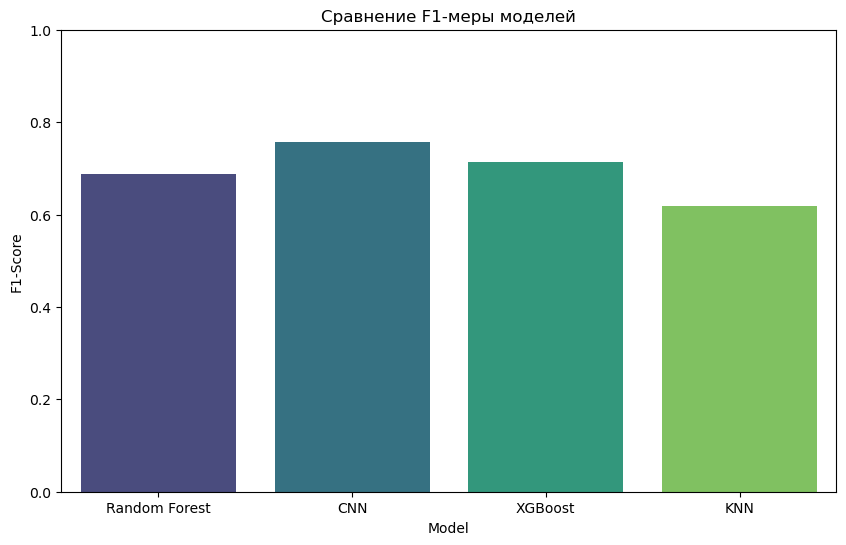

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# График сравнения точности
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')
plt.title('Сравнение точности моделей')
plt.ylim(0, 1)
plt.show()

# График сравнения F1-меры
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1-Score', data=results_df, palette='viridis')
plt.title('Сравнение F1-меры моделей')
plt.ylim(0, 1)
plt.show()

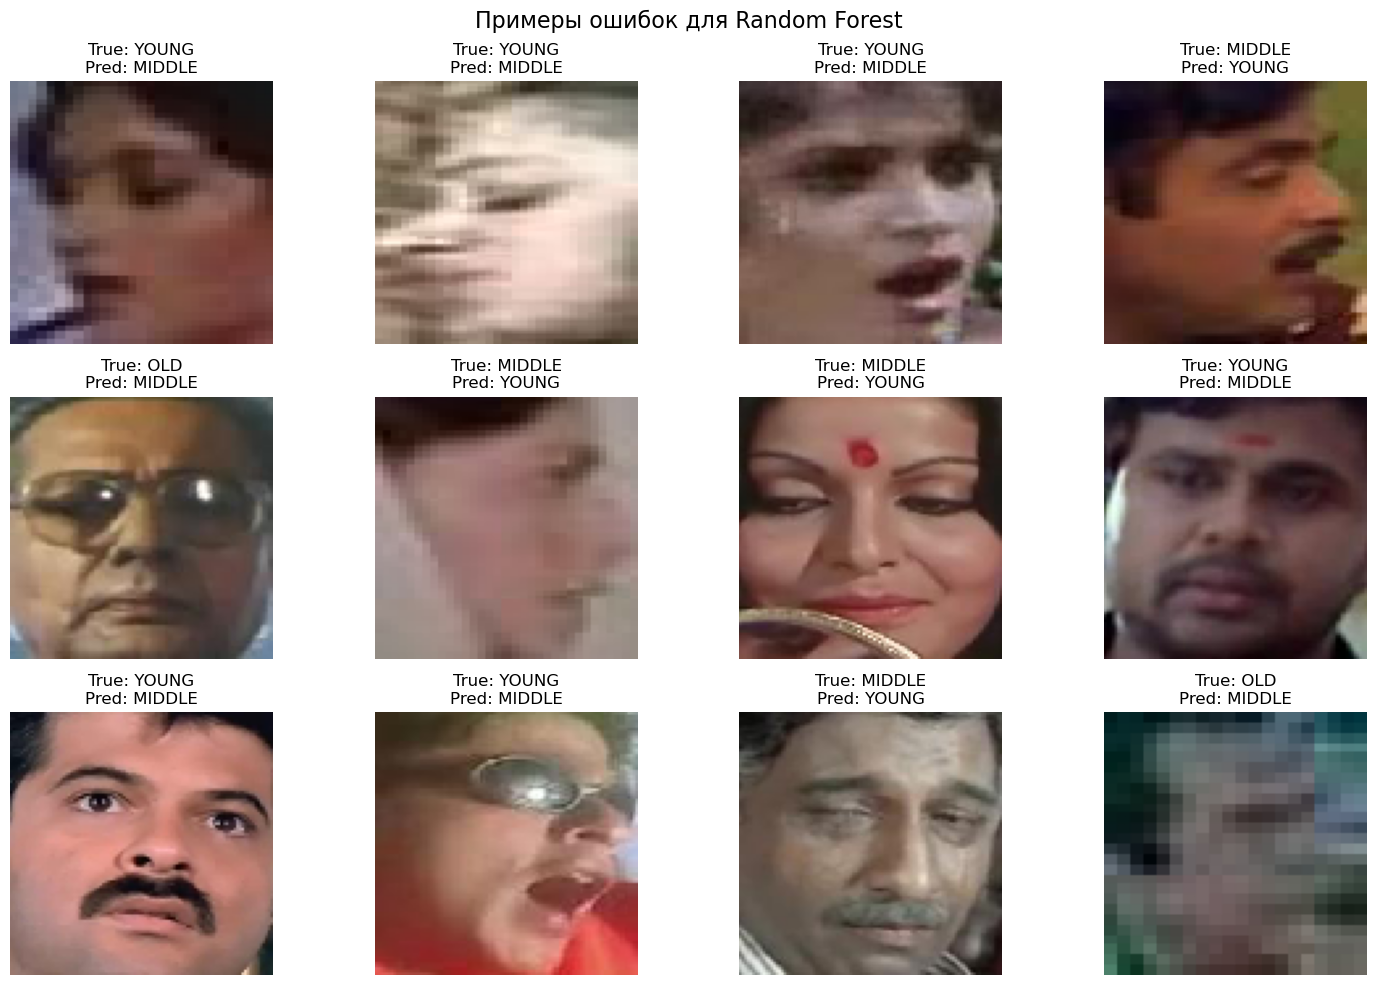

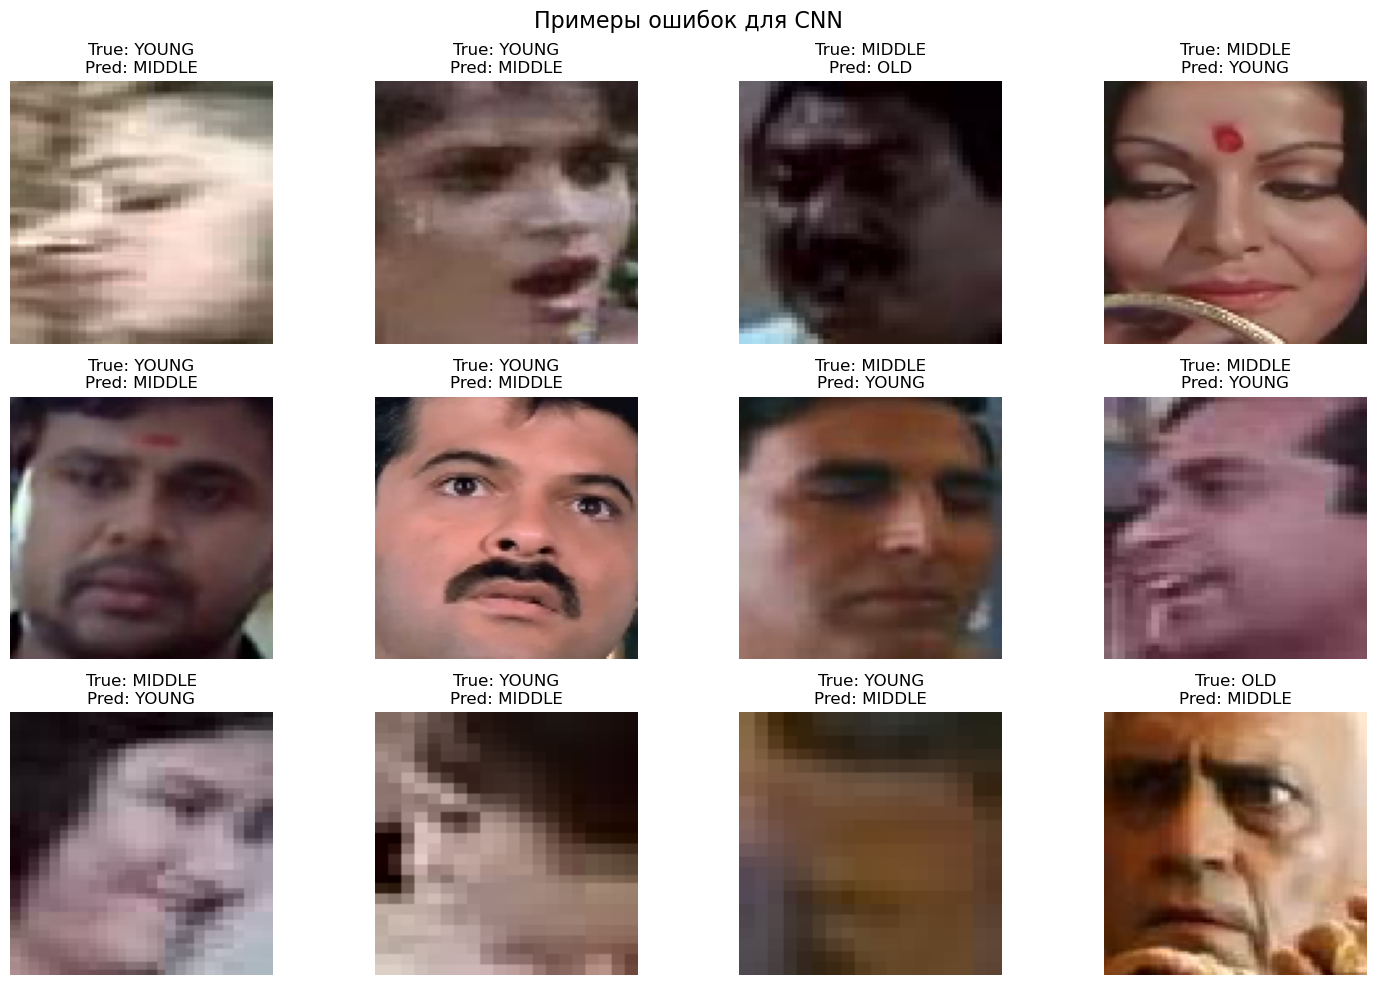

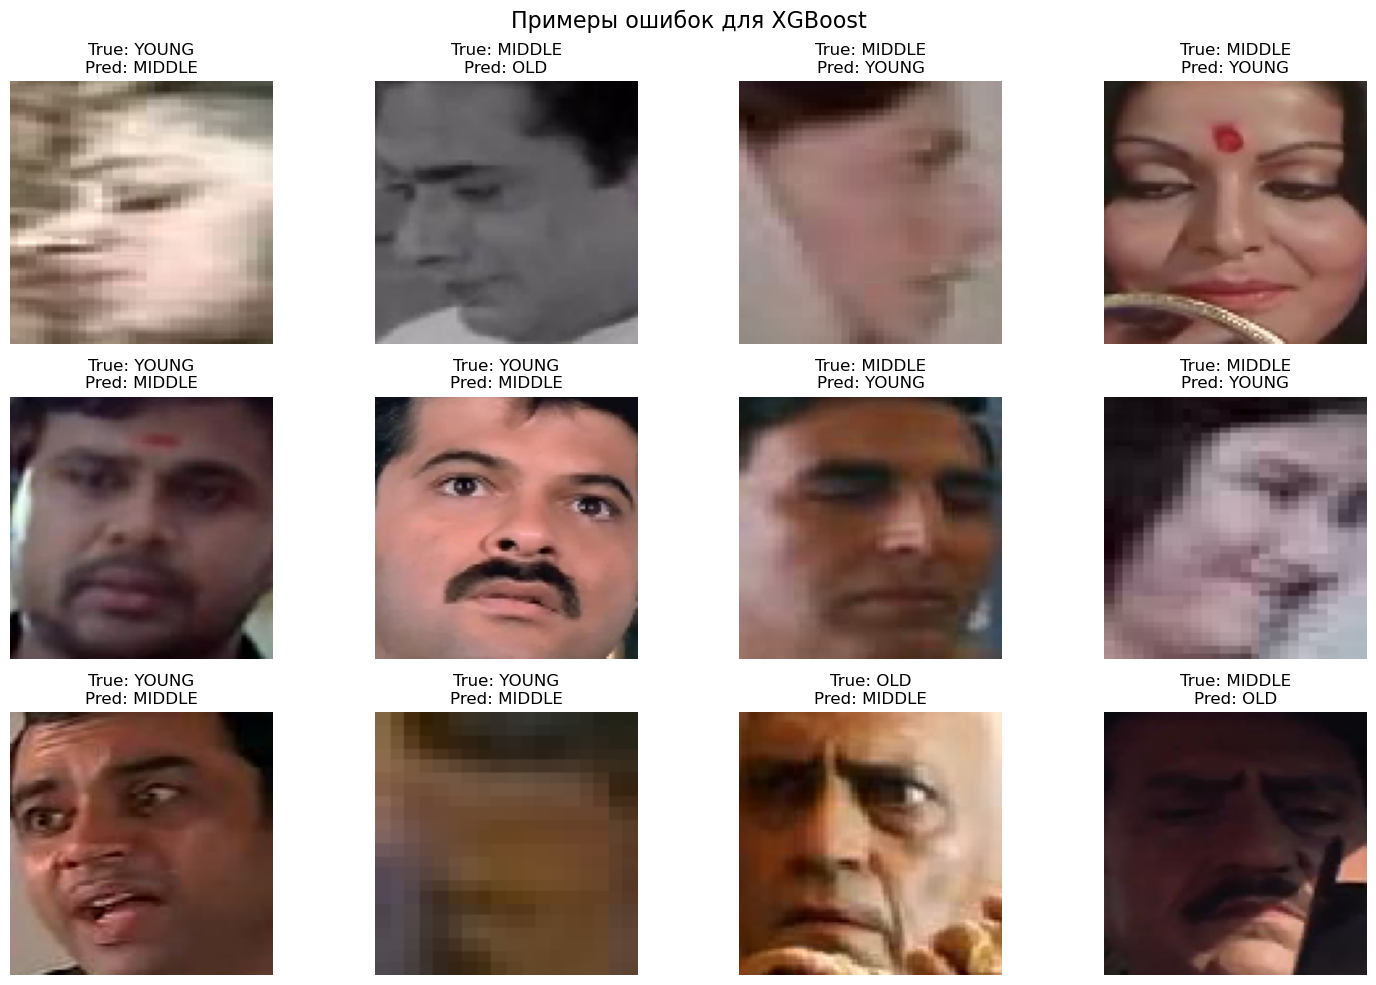

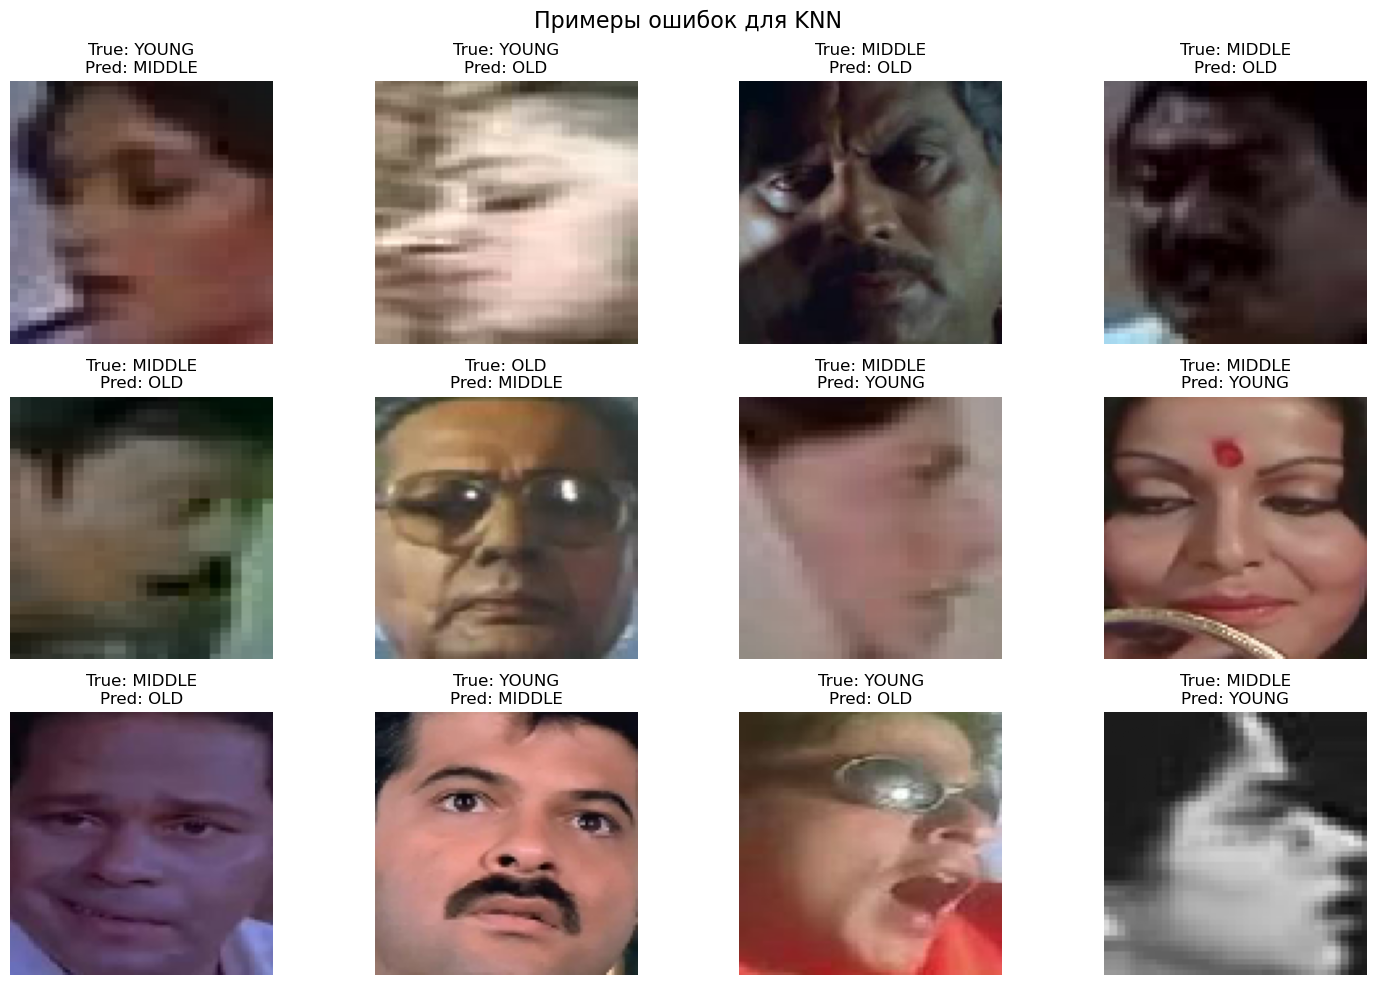

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Функция для отображения примеров ошибок
def plot_errors(images, true_labels, pred_labels, model_name, class_names):
    errors = np.where(true_labels != pred_labels)[0]
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(errors[:12]):  # Отображаем первые 12 ошибок
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[idx])  # Используем нормализованные данные
        plt.title(f'True: {class_names[true_labels[idx]]}\nPred: {class_names[pred_labels[idx]]}')
        plt.axis('off')
    plt.suptitle(f'Примеры ошибок для {model_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Классы для меток
class_names = ['YOUNG', 'MIDDLE', 'OLD']

# Отображение ошибок для всех моделей
plot_errors(test_images_normalized, y_test_rf, y_pred_rf, 'Random Forest', class_names)
plot_errors(test_images_normalized, y_test_rf, y_pred_cnn, 'CNN', class_names)
plot_errors(test_images_normalized, y_test_rf, y_pred_xgb, 'XGBoost', class_names)
plot_errors(test_images_normalized, y_test_rf, y_pred_knn, 'KNN', class_names)